# Modern Portfolio Theory

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_data

plt.style.use('seaborn')

In [44]:
PATH = 'data/modern_portfolio_theory.stocks.csv'
stocks = ["MFED.PA", "PE500.PA", "EN.PA", "CNP.PA", "TTE.PA", "RMS.PA"]

# Get stock data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

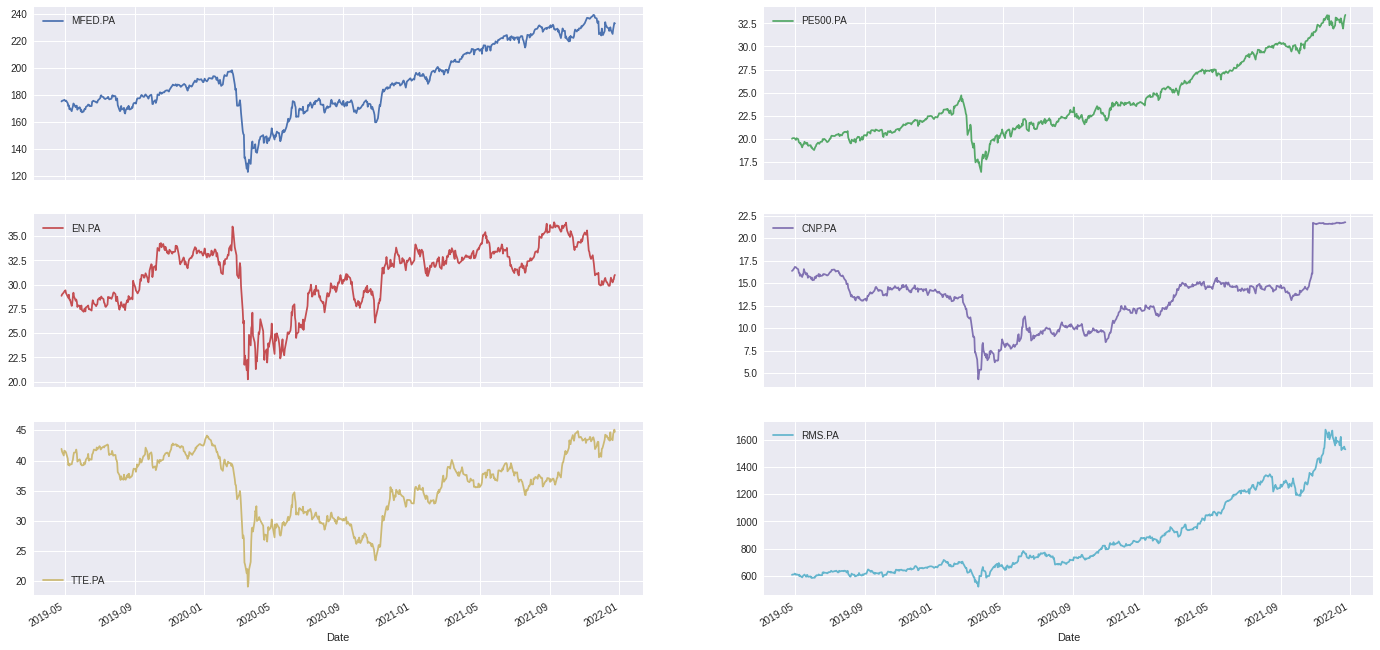

In [45]:
df = get_data(path=PATH, stocks=stocks, fetch=True)

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))

array([[<AxesSubplot:title={'center':'MFED.PA'}>,
        <AxesSubplot:title={'center':'PE500.PA'}>],
       [<AxesSubplot:title={'center':'EN.PA'}>,
        <AxesSubplot:title={'center':'CNP.PA'}>],
       [<AxesSubplot:title={'center':'TTE.PA'}>,
        <AxesSubplot:title={'center':'RMS.PA'}>]], dtype=object)

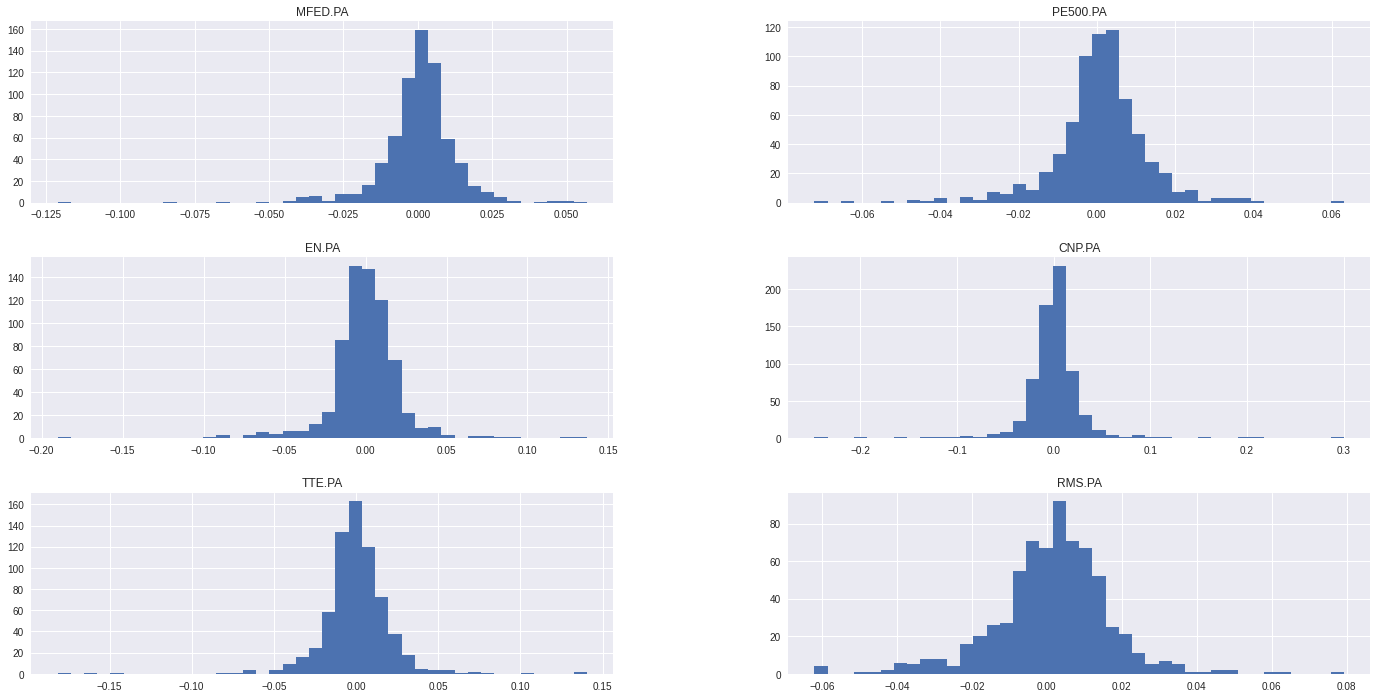

In [46]:
returns = np.log(df / df.shift(1))

returns.hist(bins=40, figsize=(24, 12))

In [47]:
returns.mean() * 252

Symbols
MFED.PA     0.104797
PE500.PA    0.188604
EN.PA       0.026462
CNP.PA      0.104718
TTE.PA      0.024115
RMS.PA      0.339249
dtype: float64

In [48]:
returns.cov() * 252

Symbols,MFED.PA,PE500.PA,EN.PA,CNP.PA,TTE.PA,RMS.PA
Symbols,,,,,,
MFED.PA,0.044427,0.030989,0.058867,0.070605,0.057981,0.035272
PE500.PA,0.030989,0.037428,0.038373,0.044018,0.038143,0.025370
EN.PA,0.058867,0.038373,0.126483,0.109207,0.086138,0.043621
CNP.PA,0.070605,0.044018,0.109207,0.262700,0.120075,0.054870
TTE.PA,0.057981,0.038143,0.086138,0.120075,0.129505,0.035638
RMS.PA,0.035272,0.025370,0.043621,0.054870,0.035638,0.061827


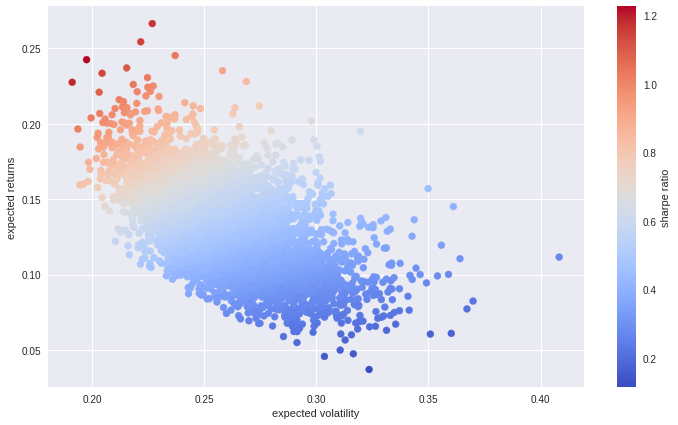

In [49]:
def portfolio_returns(weights):
    return np.sum(returns.mean() * weights) * 252
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

prets = []
pvols = []
for p in range(5000):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    prets.append(portfolio_returns(weights))
    pvols.append(portfolio_volatility(weights))
    
prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

## Find best weights

In [50]:
import scipy.optimize as sco

def min_sharpe(weights):
    return -portfolio_returns(weights) / portfolio_volatility(weights)

cons = ({
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1
})
bnds = tuple((0, 1) for _ in range(len(stocks)))
eweights = np.array(len(stocks) * [1. / len(weights)])
print(min_sharpe(eweights))

-0.512831518116419


### Weights with max Sharpe ratio

In [51]:
opts = sco.minimize(
    min_sharpe,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
print(stocks)
print('weights', opts['x'].round(3))
print('returns', portfolio_returns(opts['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(opts['x']))
print('sharpe ratio', portfolio_returns(opts['x']) / portfolio_volatility(opts['x']))

['MFED.PA', 'PE500.PA', 'EN.PA', 'CNP.PA', 'TTE.PA', 'RMS.PA']
weights [0.    0.278 0.    0.    0.    0.722]
returns 29.731 %
volatility 0.21281064943182237
sharpe ratio 1.3970626605311174


### Weights with minimum volatility

In [52]:
optv = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
print(stocks)
print('weights', optv['x'].round(3))
print('returns', portfolio_returns(optv['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(optv['x']))
print('sharpe ratio', portfolio_returns(optv['x']) / portfolio_volatility(optv['x']))

['MFED.PA', 'PE500.PA', 'EN.PA', 'CNP.PA', 'TTE.PA', 'RMS.PA']
weights [0.166 0.641 0.    0.    0.    0.193]
returns 20.384 %
volatility 0.18449372673004166
sharpe ratio 1.1048614773130563


### Efficient frontier

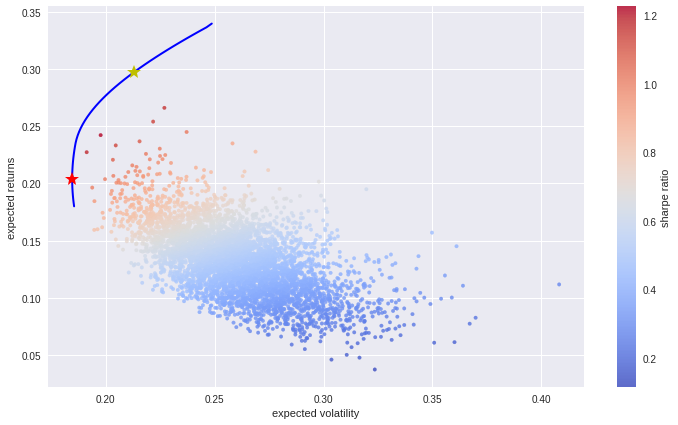

In [53]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - tret},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))

target_rets = np.linspace(0.18, 0.34, 50)
target_vols = []

for tret in target_rets:
    res = sco.minimize(
        portfolio_volatility,
        eweights,
        method='SLSQP',
        bounds=bnds,
        constraints=cons
    )
    target_vols.append(res['fun'])
target_vols = np.array(target_vols)

plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(target_vols, target_rets, 'b', lw=2.0)
plt.plot(portfolio_volatility(opts['x']), portfolio_returns(opts['x']), 'y*', markersize=15.0)
plt.plot(portfolio_volatility(optv['x']), portfolio_returns(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

### Capital market line

In [57]:
import scipy.interpolate as sci

ind = np.argmin(target_vols)
evols = target_vols[ind:]
erets = target_rets[ind:]

tck = sci.splrep(evols, erets)

def f(x):
    """ Efficient frontier function (splines approximation). """
    return sci.splev(x, tck, der=0)
def df(x):
    """ First derivative of efficient frontier function. """
    return sci.splev(x, tck, der=1)
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 2.0, 0.15])
opt

array([0.01      , 1.35032818, 0.21520243])

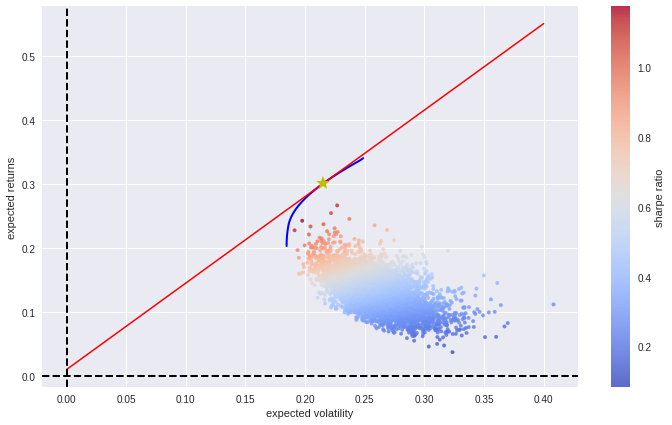

In [58]:
plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=2.0)

cx = np.linspace(0.0, 0.4)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)

plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

In [59]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - f(opt[2])},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))


res = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)

print(stocks)
print('weights', res['x'].round(3))
print('returns', portfolio_returns(res['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(res['x']))
print('sharpe ratio', portfolio_returns(res['x']) / portfolio_volatility(res['x']))

['MFED.PA', 'PE500.PA', 'EN.PA', 'CNP.PA', 'TTE.PA', 'RMS.PA']
weights [0.    0.257 0.    0.    0.    0.743]
returns 30.059 %
volatility 0.2152024344004845
sharpe ratio 1.3967960592046873
